# Spectrometry algorithms
As you may have seen in Chapter 2, going from line spectra (continuous $m/z$) to calibrated, binned profile spectra is quite the process. In `maspim` we take the fairly unique approach of estimating kernels from the added-up spectrum. Thus we avoid alignment issues that spectra-wise approaches face. Apart from that, the processing is nothing unusual:
* First we add up all uncalibrated spectra
* The noise level is estimated from the added-up spectrum
* The noise level is used to find calibrants and calibration functions for each spectrum
* Calibrated spectra are summed up
* The noise level is estimated for the sum of calibrated spectra
* The noise level is subtracted from the summed-up spectrum
* Peaks are determined in the summed spectrum and then filtered
* Kernel parameters are estimated for each peak by fitting Gaussians
* Abundances of compounds corresponding to peaks are evaluated
* A signal-to-noise ratio cutoff is applied to the abundance of each compound in each spectrum
This is the same for the targeted and untargeted branches but the peak picking method is different for the targeted approach, as will be discussed below.

## Adding spectra
$m/z$ values in the mcf files are usually not equally spaced:

C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
creating BrukerMCF reader, this may take a while ...


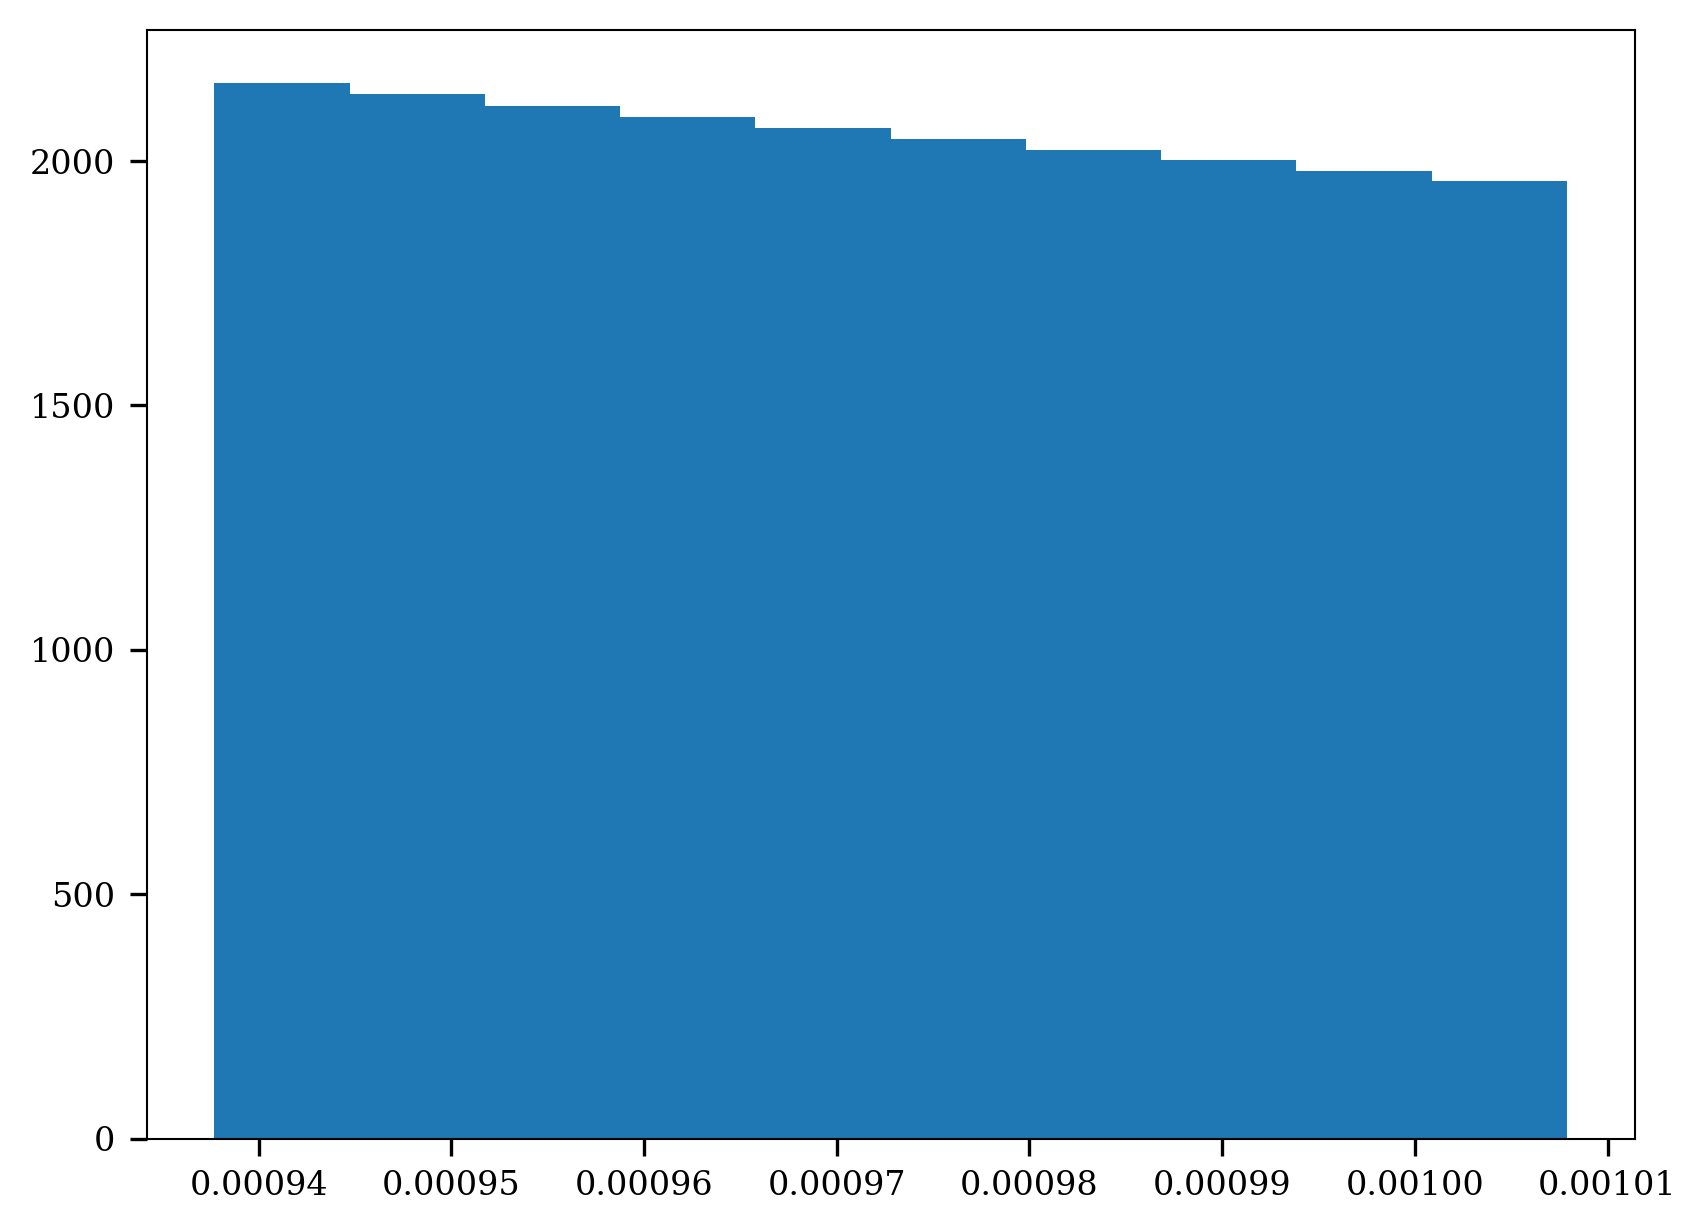

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from maspim import get_project
import user_params

project = get_project(True, user_params.path_folder_test_data)
reader = project.get_mcf_reader()

spec1 = reader.get_spectrum(1, poly_coeffs=None)

delta_mzs = np.diff(spec1.mzs)
%matplotlib inline
plt.hist(delta_mzs)
plt.show()

The deviations are small but relevant. It is more convenient to resample the intensities to regular intervals (see Chapter 2). This also ensures that every spectrum is sampled at the same $m/z$ values. We make use of `numpy`'s linear interpolation function. 

## Estimating the noise level
As mentioned above, the noise level is determined in the added-up spectrum. This has the advantage of obtaining a fairly smooth line in which real peaks are clearly distinguishable due to noise cancelation over many measurements. In the summed-up spectrum, the noise level looks more like a baseline. Take a look at the example below: peaks appear to be *riding* on a small hill. In `maspim` we assume that this is caused by higher noise values around areas with higher total ion counts. The baseline in the added-up spectrum is estimated by applying a 
* minimum filter (smallest value inside a certain window around each value)
* median filter (central value of the previous result with the same window size)

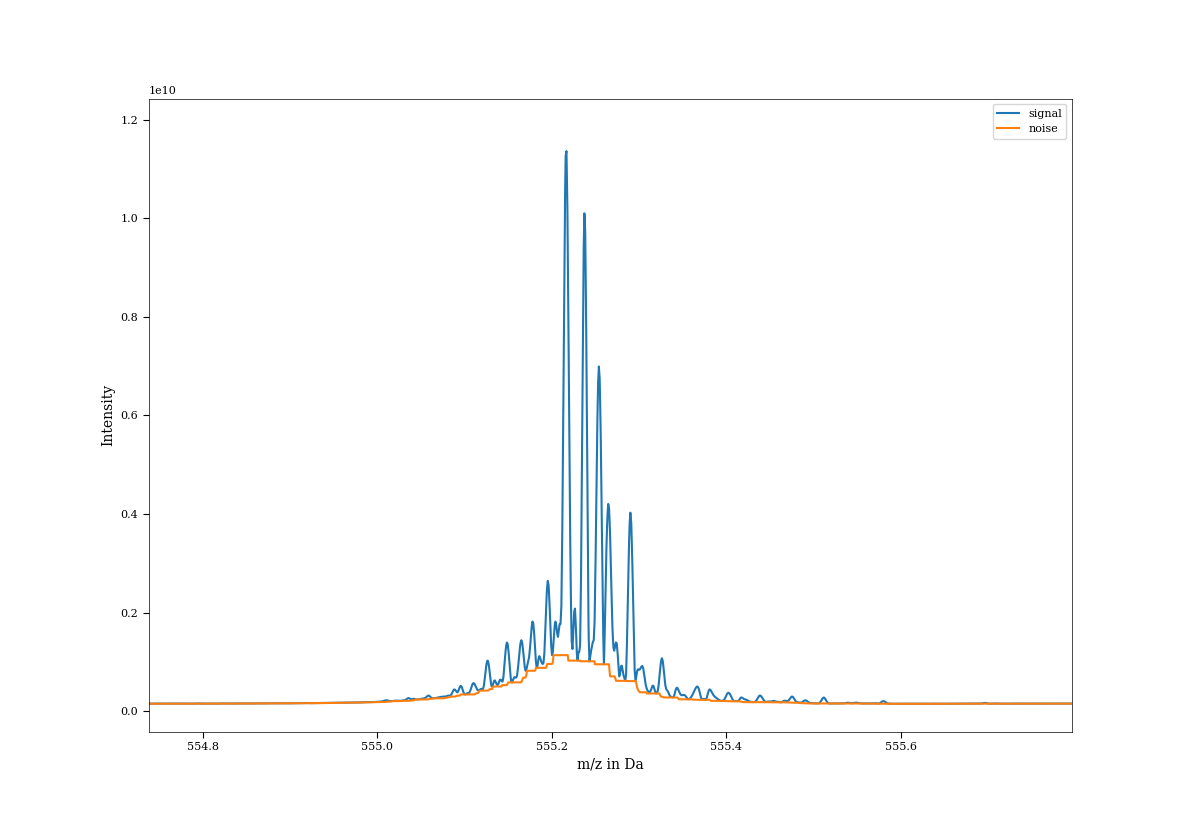

The noise level is then taken to be the baseline divided by the number of spectra (this assumes the noise level is the same in each spectrum). Since the noise level is higher around peaks, when we filter by SNR, stricter filtering is applied to values close to peaks. In DataAnalysis the opposite is true, noise levels are estimated to be lower around peaks. We should acknowledge that both methods have their advantages but being more sensitive to values around small peaks appears reasonable in our applications as yields can be quite low. Take a look at a comparison of estimated noise levels below. Here we are just looking at a single spectrum (blue) The anti-correlated courses explain why DataAnalysis requires SNR thresholds of around 4 whereas in `maspim` SNR thresholds slightly above 1 are more reasonable. This is likely because the uses of the SNR thresholds are different: DataAnalysis tries to determine which values could be peaks whereas in `maspim` we know where to find peaks (from the summed-up spectrum) but we don't know a priori which values are noise or real signal.

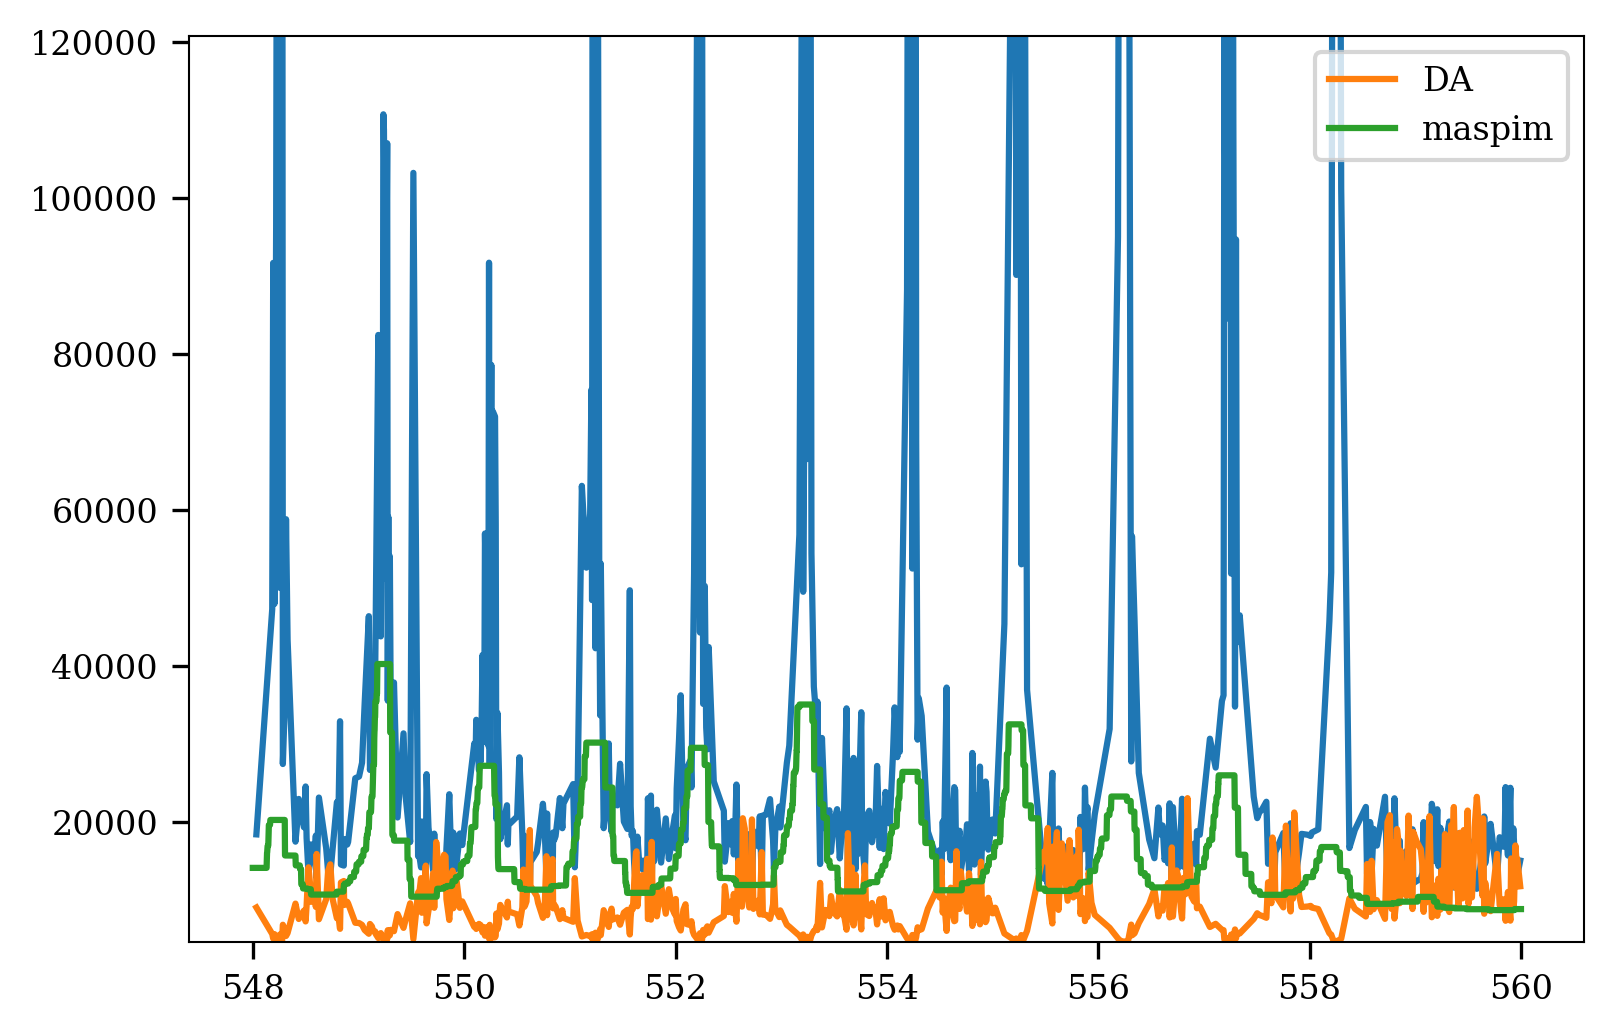

## Calibration
The noise level is important for deciding whether a peak is a suitable candidate for matching a peak to a calibrant. A wrong match is worse than no calibration hence we recommend applying fairly strict criteria for finding candidates (an SNR of at least 4 and a search range of $\pm 5\,\text{mDa}$ by default). A polynomial of the required degree (default: linear) is then estimated to that would warp the spectrum such that distances are minimized. This step requires that peaks are determined in each spectrum. For this, we are using `scipy`'s `find_peaks` function.

## Peak picking
### Untargetd
Peaks are picked above a certain prominence (default: at least 10 % of median) using `find_peaks` again.

### Targeted
Peaks are either set to the theoretical mass (default) or the closest detected peak.

## Kernel estimation
The parameters of Gaussians are first roughly estimated from the peak height and full width at half maximum (which is proportional to the standard deviation $\sigma$. Then, using the parameters from before, curve fitting is performed to fine-tune the parameters. 

In the targeted approach the height is taken at the peak center and the standard deviation is the provided tolerance (default: 3 mDa)

## Binning
The default method ('height') takes the intensities at the determined peak positions for each spectrum, even if the apex in the spectrum is shifted. 
The 'max' method takes the apex for each compound and spectrum but assigns 0 if the maximum is at the boundary of the window which indicates that the peak is outside the tolerance window.
The 'area' method calculates the overlap of the kernel and spectrum. 

The result of all of those methods is a table in which each column corresponds to a compound and each row to a spectrum. 

## Filtering
Using the noise level from above, the SNR of each compound in each spectrum is determined and values below a cutoff value are set to 0.

